In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm, skew, boxcox_normmax
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [4]:
#Load the we_fn_use_c_marketing_customer_value_analysis.csv into the variable customer_df.
# Reading csv as a dataframe

customer_df = pd.read_csv('./files_for_lab/we_fn_use_c_marketing_customer_value_analysis.csv')
customer_df

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9129,LA72316,California,23405.987980,No,Basic,Bachelor,2/10/11,Employed,M,71941,Urban,Married,73,18,89,0,2,Personal Auto,Personal L1,Offer2,Web,198.234764,Four-Door Car,Medsize
9130,PK87824,California,3096.511217,Yes,Extended,College,2/12/11,Employed,F,21604,Suburban,Divorced,79,14,28,0,1,Corporate Auto,Corporate L3,Offer1,Branch,379.200000,Four-Door Car,Medsize
9131,TD14365,California,8163.890428,No,Extended,Bachelor,2/6/11,Unemployed,M,0,Suburban,Single,85,9,37,3,2,Corporate Auto,Corporate L2,Offer1,Branch,790.784983,Four-Door Car,Medsize
9132,UP19263,California,7524.442436,No,Extended,College,2/3/11,Employed,M,21941,Suburban,Married,96,34,3,0,3,Personal Auto,Personal L2,Offer3,Branch,691.200000,Four-Door Car,Large


In [5]:
#Rename the columns so they follow the PE8 (snake case).
# Standardization of header names
def standardization(df):
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ','_')

In [6]:
standardization(customer_df)
customer_df.head()

,customer,state,customer_lifetime_value,response,coverage,education,effective_to_date,employmentstatus,gender,income,location_code,marital_status,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,policy_type,policy,renew_offer_type,sales_channel,total_claim_amount,vehicle_class,vehicle_size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [7]:
# Change effective to date column to datetime format.
customer_df['effective_to_date'] = pd.to_datetime(customer_df['effective_to_date'])

In [8]:
customer_df['effective_to_date']


0      2011-02-24
1      2011-01-31
2      2011-02-19
3      2011-01-20
4      2011-02-03
          ...    
9129   2011-02-10
9130   2011-02-12
9131   2011-02-06
9132   2011-02-03
9133   2011-02-14
Name: effective_to_date, Length: 9134, dtype: datetime64[ns]

In [9]:
# Check NaN values per column.
def nulls_data(df):
    nulls_df = pd.DataFrame(round(df.isna().sum()/len(df)*100,2))
    nulls_df = nulls_df.reset_index()
    nulls_df.columns = ['header_name', '%_null_values'] 
    return nulls_df
nulls_data(customer_df)

,header_name,%_null_values
0,customer,0.0
1,state,0.0
2,customer_lifetime_value,0.0
3,response,0.0
4,coverage,0.0
5,education,0.0
6,effective_to_date,0.0
7,employmentstatus,0.0
8,gender,0.0
9,income,0.0


In [10]:
# Define a function that differentiates between continuous and discrete variables. Hint: A number of unique values might be useful. Store continuous data into a continuous variable and do the same for discrete and categorical.
num = customer_df.select_dtypes(include = np.number)
cat = customer_df.select_dtypes(include = np.object)
categorical_columns = customer_df.select_dtypes(include=['object']).columns.tolist()
categorical_columns

['customer',
 'state',
 'response',
 'coverage',
 'education',
 'employmentstatus',
 'gender',
 'location_code',
 'marital_status',
 'policy_type',
 'policy',
 'renew_offer_type',
 'sales_channel',
 'vehicle_class',
 'vehicle_size']

In [11]:
#Load the continuous and discrete variables into continuous_df and discrete_df variables.
def continuous_discrete(df):
    numerical_columns = df.select_dtypes(exclude=['object']).columns.tolist()
    continuos = []
    discrete = []
    for col in numerical_columns:
        if df[col].nunique() / len(df[col]) <= 0.05:
            discrete.append(col)
        else:
            continuos.append(col)
    return df[continuos], df[discrete] 

In [12]:
continuous_df, discrete_df = continuous_discrete(customer_df)
continuous_df

,customer_lifetime_value,income,total_claim_amount
0,2763.519279,56274,384.811147
1,6979.535903,0,1131.464935
2,12887.431650,48767,566.472247
3,7645.861827,0,529.881344
4,2813.692575,43836,138.130879
...,...,...,...
9129,23405.987980,71941,198.234764
9130,3096.511217,21604,379.200000
9131,8163.890428,0,790.784983
9132,7524.442436,21941,691.200000


In [13]:
discrete_df


,effective_to_date,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies
0,2011-02-24,69,32,5,0,1
1,2011-01-31,94,13,42,0,8
2,2011-02-19,108,18,38,0,2
3,2011-01-20,106,18,65,0,7
4,2011-02-03,73,12,44,0,1
...,...,...,...,...,...,...
9129,2011-02-10,73,18,89,0,2
9130,2011-02-12,79,14,28,0,1
9131,2011-02-06,85,9,37,3,2
9132,2011-02-03,96,34,3,0,3


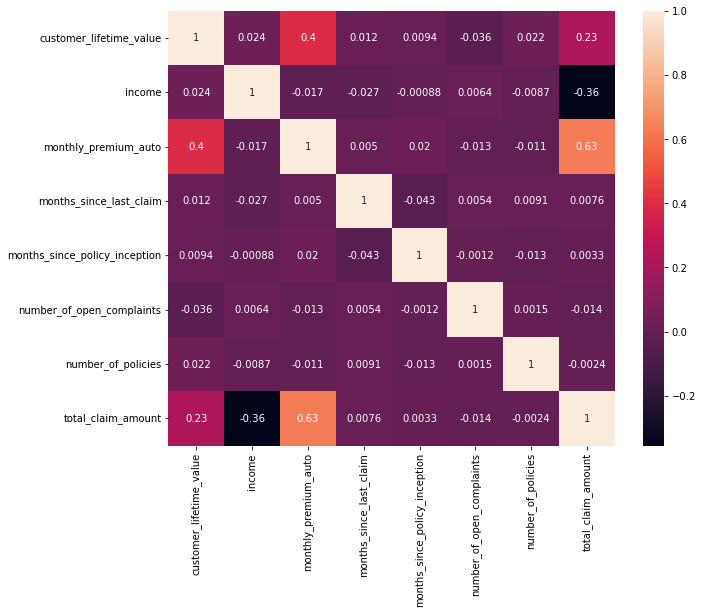

In [14]:
#Plot a correlation matrix, what can you see? monthly_premium_auto and total_claim_amount have the highest correlation to each other
corr_matrix=num.corr(method='pearson')  
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [15]:
#Create a function to plot every discrete variables. Do the same with continuous variables (be careful, you may change the plot type to another one better suited for continuous data).
def plot_discrete(df,cols_disc):

     for col in cols_disc:
        print("Frequency analysis of column: ",col)
        my_data = df[col].value_counts().reset_index()
        ax = sns.barplot(x=col, y="index", data = my_data).set_title(col.upper())
        plt.figure()
        print()

In [16]:
discrete = discrete_df.copy()
#discrete_df.drop(['effect'])

In [17]:
discrete = discrete.drop(['effective_to_date'],axis=1)


Frequency analysis of column:  monthly_premium_auto

Frequency analysis of column:  months_since_last_claim

Frequency analysis of column:  months_since_policy_inception

Frequency analysis of column:  number_of_open_complaints

Frequency analysis of column:  number_of_policies



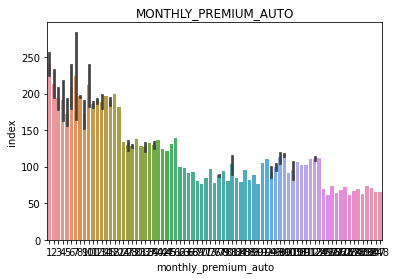

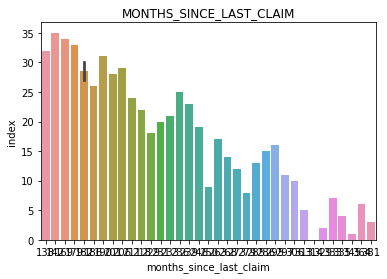

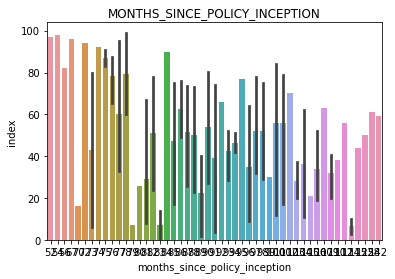

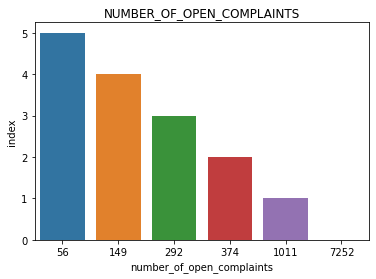

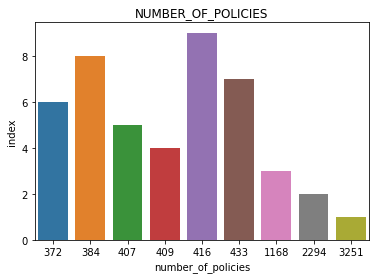

<Figure size 432x288 with 0 Axes>

In [18]:
cols_disc = discrete.columns
plot_discrete(discrete_df,cols_disc)

In [19]:
def plot_continuous(df,cols):
    for col in cols:
        sns.distplot(df[col],bins= 100, 
                       color = 'blue')
        plt.title('Distribution')
        plt.show()

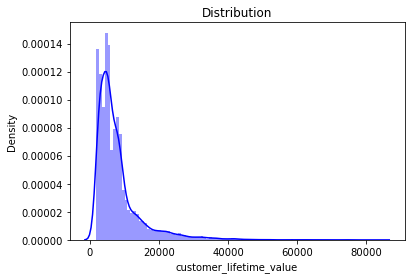

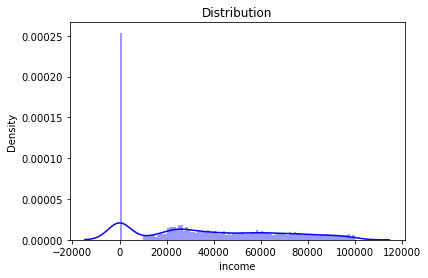

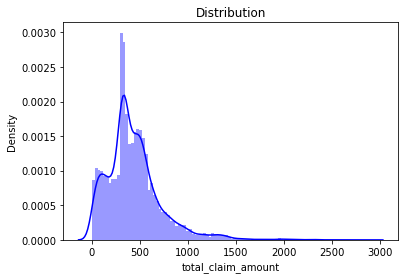

In [20]:
#What can you see in the plots? - Answer: The distributions are not normal and they are skewed
cols_con = continuous_df.columns
plot_continuous(continuous_df,cols_con)

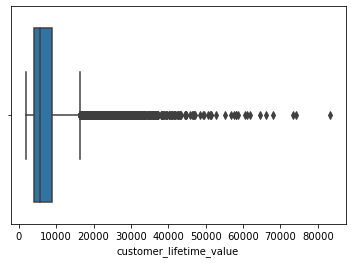

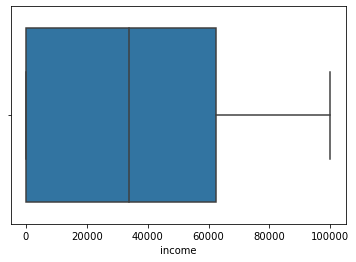

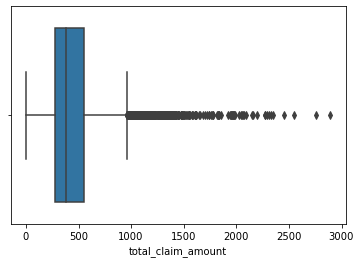

In [21]:
#We will start with removing outliers. So far, we have discussed different methods to remove outliers. Use the one you feel more comfortable with, define a function for that. Use the function to remove the outliers and apply it to the dataframe.
# checking for outliers
for col in cols_con:
    sns.boxplot(continuous_df[col])
    plt.show()
    


In [22]:
# Remove the outliers 

iqr1=np.percentile(continuous_df['customer_lifetime_value'],75)-np.percentile(continuous_df['customer_lifetime_value'],25)
upper_limit1=np.percentile(continuous_df['customer_lifetime_value'],75) +1.5*iqr1
lower_limit1=np.percentile(continuous_df['customer_lifetime_value'],75) -1.5*iqr1
upper_limit1, lower_limit1

(16414.039911750002, 1510.2941707499995)

In [23]:
customer_df = customer_df[(continuous_df['customer_lifetime_value'] > lower_limit1) & (continuous_df['customer_lifetime_value'] < upper_limit1)]
customer_df = customer_df.reset_index()
customer_df=customer_df.drop(['index'], axis=1)
customer_df['customer_lifetime_value']

0        2763.519279
1        6979.535903
2       12887.431650
3        7645.861827
4        2813.692575
            ...     
8312     4100.398533
8313     3096.511217
8314     8163.890428
8315     7524.442436
8316     2611.836866
Name: customer_lifetime_value, Length: 8317, dtype: float64

<AxesSubplot:xlabel='customer_lifetime_value'>

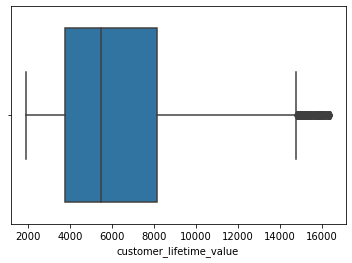

In [24]:
sns.boxplot(customer_df['customer_lifetime_value'])


In [25]:
iqr2=np.percentile(continuous_df['total_claim_amount'],75)-np.percentile(continuous_df['total_claim_amount'],25)
upper_limit2=np.percentile(continuous_df['total_claim_amount'],75) +1.5*iqr1
lower_limit2=np.percentile(continuous_df['total_claim_amount'],75) -1.5*iqr1
upper_limit2, lower_limit2

(7999.3877092500015, -6904.358031750001)

In [26]:
customer_df = customer_df[(continuous_df['total_claim_amount'] > lower_limit2) & (continuous_df['total_claim_amount'] < upper_limit2)]
customer_df = customer_df.reset_index()
customer_df=customer_df.drop(['index'], axis=1)
customer_df['total_claim_amount']

0        384.811147
1       1131.464935
2        566.472247
3        529.881344
4        138.130879
           ...     
8312     541.282007
8313     379.200000
8314     790.784983
8315     691.200000
8316     369.600000
Name: total_claim_amount, Length: 8317, dtype: float64

In [27]:
# correcting again the dataframes for discerete and continious numerical as well as categorical variables after removing outliers
num = customer_df.select_dtypes(include = np.number)
cat = customer_df.select_dtypes(include = np.object)

In [28]:
continuous_df2, discrete_df2 = continuous_discrete(customer_df)


In [29]:
# Plot all the categorical variables with the proper plot. 
def plot_cat(df,cols):

     for col in cols:
        print("Frequency analysis of column: ",col)
        my_data = df[col].value_counts().reset_index()
        ax = sns.barplot(x=col, y="index", data = my_data).set_title(col.upper())
        plt.figure()
        print()

In [30]:
cat=cat.drop(['customer'],axis=1)


Frequency analysis of column:  state

Frequency analysis of column:  response

Frequency analysis of column:  coverage

Frequency analysis of column:  education

Frequency analysis of column:  employmentstatus

Frequency analysis of column:  gender

Frequency analysis of column:  location_code

Frequency analysis of column:  marital_status

Frequency analysis of column:  policy_type

Frequency analysis of column:  policy

Frequency analysis of column:  renew_offer_type

Frequency analysis of column:  sales_channel

Frequency analysis of column:  vehicle_class

Frequency analysis of column:  vehicle_size



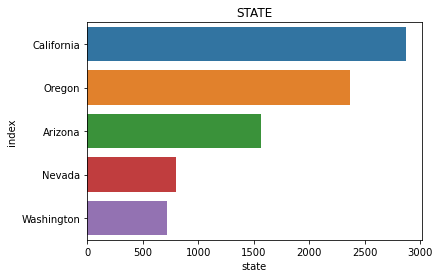

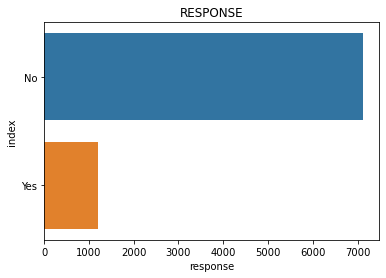

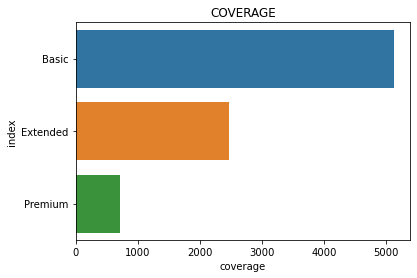

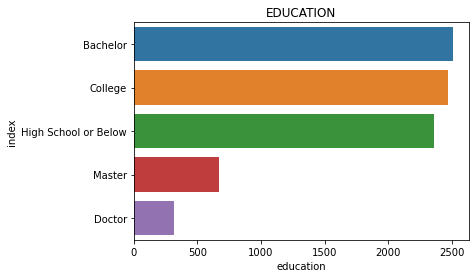

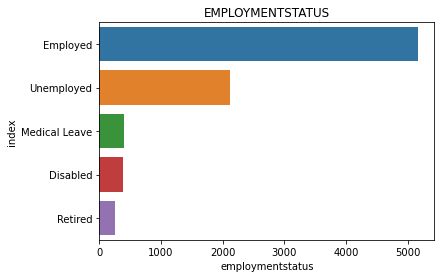

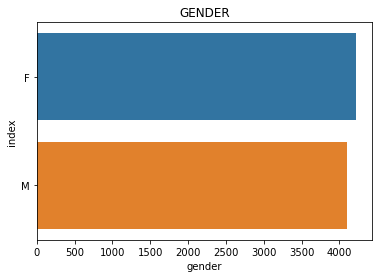

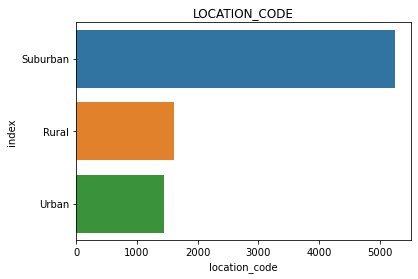

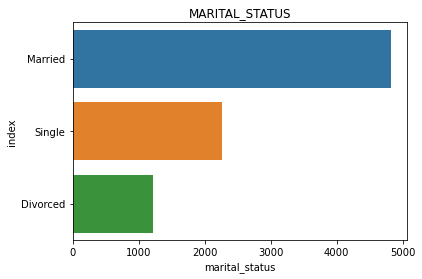

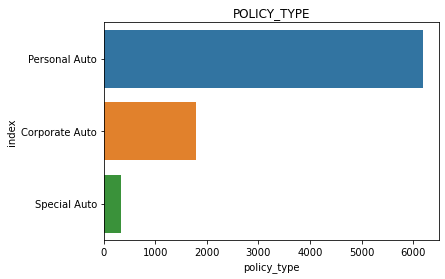

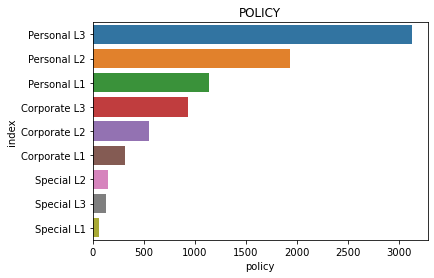

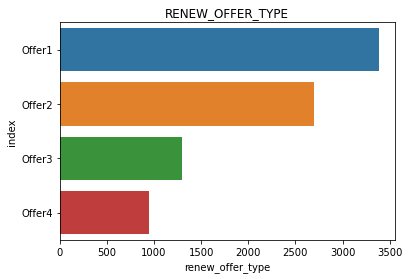

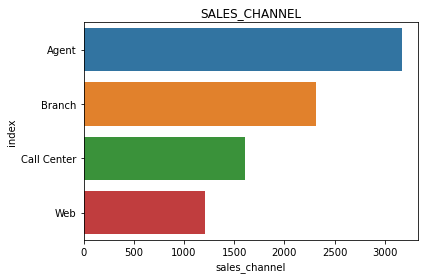

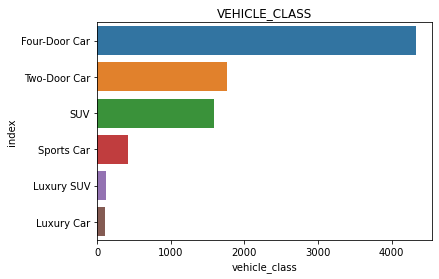

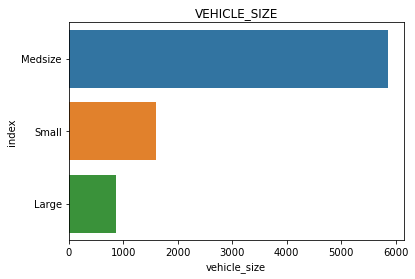

<Figure size 432x288 with 0 Axes>

In [31]:
categorical_columns = cat.columns
plot_cat(cat,categorical_columns)

In [32]:
# For the categorical data, check if there is some kind of text in a variable so we would need to clean it. Hint: Use the same method you used in step 7. Depending on the implementation, decide what to do with the variables you get.
for col in categorical_columns:
    print(f'Unique values for column {col.upper()}\n{cat[col].value_counts()}')

Unique values for column STATE
California    2869
Oregon        2368
Arizona       1565
Nevada         799
Washington     716
Name: state, dtype: int64
Unique values for column RESPONSE
No     7123
Yes    1194
Name: response, dtype: int64
Unique values for column COVERAGE
Basic       5132
Extended    2462
Premium      723
Name: coverage, dtype: int64
Unique values for column EDUCATION
Bachelor                2505
College                 2466
High School or Below    2359
Master                   671
Doctor                   316
Name: education, dtype: int64
Unique values for column EMPLOYMENTSTATUS
Employed         5173
Unemployed       2116
Medical Leave     397
Disabled          374
Retired           257
Name: employmentstatus, dtype: int64
Unique values for column GENDER
F    4214
M    4103
Name: gender, dtype: int64
Unique values for column LOCATION_CODE
Suburban    5255
Rural       1616
Urban       1446
Name: location_code, dtype: int64
Unique values for column MARITAL_STATUS
Marri

In [33]:
#There might be some columns that seem to be redundant, check their values to be sure. What should we do with them?

def fix_policy_type(x):
    
        x = x.replace(" ","")
        x = x.replace('Auto',"")
        return x

In [34]:
def fix_policy(x):
    dictionary = {" ":"", "Corporate":"","Personal":"", "Special":"" } 
    for key in dictionary.keys():
        x = x.replace(key, dictionary[key])
    return x

In [35]:
cat['policy'] = cat['policy'].apply(fix_policy)
cat['policy_type'] = cat['policy_type'].apply(fix_policy_type)

In [36]:
cat['policy']


0       L3
1       L3
2       L3
3       L2
4       L1
        ..
8312    L2
8313    L3
8314    L2
8315    L2
8316    L3
Name: policy, Length: 8317, dtype: object

In [37]:
cat['policy_type']


0       Corporate
1        Personal
2        Personal
3       Corporate
4        Personal
          ...    
8312     Personal
8313    Corporate
8314    Corporate
8315     Personal
8316    Corporate
Name: policy_type, Length: 8317, dtype: object

In [38]:
#Plot time variable. Can you extract something from it?
time_series = pd.DataFrame(customer_df['effective_to_date'].value_counts().reset_index())
                        
time_series.columns =['date', 'count']

(array([14975., 14982., 14989., 14996., 15006., 15013., 15020., 15027.,
        15034.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

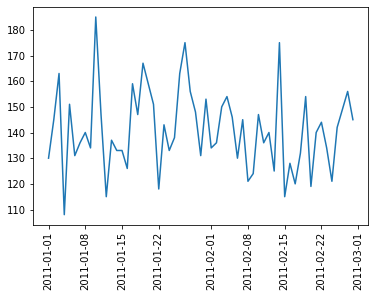

In [39]:
time_series = time_series.sort_values('date', ascending = True)
plt.plot(time_series['date'], time_series['count'])
plt.xticks(rotation = 'vertical')

In [40]:
#Create a copy of the dataframe for the data wrangling.
data_org = customer_df.copy()
num_org = num.copy()
cat_org = cat.copy()

In [42]:

# normalization of the data
transformer = StandardScaler().fit(continuous_df2)
continuous_df2 = transformer.transform(continuous_df2)
continuous_df2

array([[-1.08500227,  0.61273838, -0.13868698],
       [ 0.21614443, -1.23755793,  2.56993744],
       [ 2.03943873,  0.36590726,  0.52032219],
       ...,
       [ 0.58165983, -1.23755793,  1.33405804],
       [ 0.38431344, -0.51613504,  0.97279513],
       [-1.13181448, -1.23755793, -0.19386822]])

In [43]:
continuous_df_org = pd.DataFrame(continuous_df2)


In [44]:
discrete_df_org = discrete_df2


In [45]:
# Encode the categorical variables
cat_org

,state,response,coverage,education,employmentstatus,gender,location_code,marital_status,policy_type,policy,renew_offer_type,sales_channel,vehicle_class,vehicle_size
0,Washington,No,Basic,Bachelor,Employed,F,Suburban,Married,Corporate,L3,Offer1,Agent,Two-Door Car,Medsize
1,Arizona,No,Extended,Bachelor,Unemployed,F,Suburban,Single,Personal,L3,Offer3,Agent,Four-Door Car,Medsize
2,Nevada,No,Premium,Bachelor,Employed,F,Suburban,Married,Personal,L3,Offer1,Agent,Two-Door Car,Medsize
3,California,No,Basic,Bachelor,Unemployed,M,Suburban,Married,Corporate,L2,Offer1,Call Center,SUV,Medsize
4,Washington,No,Basic,Bachelor,Employed,M,Rural,Single,Personal,L1,Offer1,Agent,Four-Door Car,Medsize
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8312,California,No,Premium,College,Employed,F,Suburban,Single,Personal,L2,Offer1,Branch,Four-Door Car,Large
8313,California,Yes,Extended,College,Employed,F,Suburban,Divorced,Corporate,L3,Offer1,Branch,Four-Door Car,Medsize
8314,California,No,Extended,Bachelor,Unemployed,M,Suburban,Single,Corporate,L2,Offer1,Branch,Four-Door Car,Medsize
8315,California,No,Extended,College,Employed,M,Suburban,Married,Personal,L2,Offer3,Branch,Four-Door Car,Large


In [46]:
# For columns 'coverage' and 'education' LabelEncoder could be used because they are ordinal data

label1 = preprocessing.LabelEncoder()
cat_org['education'] = label1.fit_transform(cat_org['education'])
cat_org['education']
# labelencoder assigns values to categories alphabetically which does not have a correct order for education collumn and it must be corrected!
# I did it using replace
cat_org['education'] = cat_org['education'].replace({0:2, 1:1, 2:4, 3:0, 4:3})
cat_org['education']

0       2
1       2
2       2
3       2
4       2
       ..
8312    1
8313    1
8314    2
8315    1
8316    1
Name: education, Length: 8317, dtype: int64

In [47]:
# encode the other categorical columnss 
cat_org= pd.get_dummies(cat_org,drop_first=True)
cat_org

,education,state_California,state_Nevada,state_Oregon,state_Washington,response_Yes,coverage_Extended,coverage_Premium,employmentstatus_Employed,employmentstatus_Medical Leave,employmentstatus_Retired,employmentstatus_Unemployed,gender_M,location_code_Suburban,location_code_Urban,marital_status_Married,marital_status_Single,policy_type_Personal,policy_type_Special,policy_L2,policy_L3,renew_offer_type_Offer2,renew_offer_type_Offer3,renew_offer_type_Offer4,sales_channel_Branch,sales_channel_Call Center,sales_channel_Web,vehicle_class_Luxury Car,vehicle_class_Luxury SUV,vehicle_class_SUV,vehicle_class_Sports Car,vehicle_class_Two-Door Car,vehicle_size_Medsize,vehicle_size_Small
0,2,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0
1,2,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0
2,2,0,1,0,0,0,0,1,1,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0
3,2,1,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0
4,2,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8312,1,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
8313,1,1,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0
8314,2,1,0,0,0,0,1,0,0,0,0,1,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
8315,1,1,0,0,0,0,1,0,1,0,0,0,1,1,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0


In [48]:
# The time variable can be useful. Try to transform its data into a useful one. Hint: Day week and month as integers might be useful.
discrete_df_org['week']= discrete_df_org['effective_to_date'].dt.dayofweek

In [49]:
discrete_df_org['week']


0       3
1       0
2       5
3       3
4       3
       ..
8312    3
8313    5
8314    6
8315    3
8316    0
Name: week, Length: 8317, dtype: int64

In [50]:
discrete_df_org['month']= pd.to_datetime(discrete_df_org['effective_to_date']).dt.month
discrete_df_org['month']

0       2
1       1
2       2
3       1
4       2
       ..
8312    1
8313    2
8314    2
8315    2
8316    2
Name: month, Length: 8317, dtype: int64

In [51]:
discrete_df_org = discrete_df_org.drop(['effective_to_date'],axis=1)


In [52]:
data_customer = pd.concat([cat_org, discrete_df_org,continuous_df_org],axis= 1)
#data_customer = np.concatenate((cat_org, discrete_df_org,continuous_df_org))

In [53]:
data_customer


,education,state_California,state_Nevada,state_Oregon,state_Washington,response_Yes,coverage_Extended,coverage_Premium,employmentstatus_Employed,employmentstatus_Medical Leave,employmentstatus_Retired,employmentstatus_Unemployed,gender_M,location_code_Suburban,location_code_Urban,marital_status_Married,marital_status_Single,policy_type_Personal,policy_type_Special,policy_L2,policy_L3,renew_offer_type_Offer2,renew_offer_type_Offer3,renew_offer_type_Offer4,sales_channel_Branch,sales_channel_Call Center,sales_channel_Web,vehicle_class_Luxury Car,vehicle_class_Luxury SUV,vehicle_class_SUV,vehicle_class_Sports Car,vehicle_class_Two-Door Car,vehicle_size_Medsize,vehicle_size_Small,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,week,month,0,1,2
0,2,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,69,32,5,0,1,3,2,-1.085002,0.612738,-0.138687
1,2,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,94,13,42,0,8,0,1,0.216144,-1.237558,2.569937
2,2,0,1,0,0,0,0,1,1,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,108,18,38,0,2,5,2,2.039439,0.365907,0.520322
3,2,1,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,106,18,65,0,7,3,1,0.421786,-1.237558,0.387582
4,2,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,73,12,44,0,1,3,2,-1.069518,0.203775,-1.033565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8312,1,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,104,16,58,0,1,3,1,-0.672415,0.332830,0.428940
8313,1,1,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,79,14,28,0,1,5,2,-0.982234,-0.527216,-0.159042
8314,2,1,0,0,0,0,1,0,0,0,0,1,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,85,9,37,3,2,6,2,0.581660,-1.237558,1.334058
8315,1,1,0,0,0,0,1,0,1,0,0,0,1,1,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,96,34,3,0,3,3,2,0.384313,-0.516135,0.972795


In [54]:
X = data_customer
y = customer_df['total_claim_amount']

In [55]:
# In this final lab, we will model our data. Import sklearn train_test_split and separate the data.

# Split data to training and test sets

x_train,x_test, y_train, y_test = train_test_split(X,y, test_size= 0.20, random_state=100)

In [56]:
#Try a simple linear regression with all the data to see whether we are getting good results.
lreg = LinearRegression()
lreg.fit(x_train, y_train)

LinearRegression()

In [57]:
score = lreg.score(x_test, y_test)
score

1.0

In [58]:
score_train = lreg.score(x_train, y_train)
score_train

1.0

In [59]:
#Now define a function that takes a list of models and train (and tests) them so we can try a lot of them without repeating code.


def models (x_train,y_train,x_test,y_test):
    scores=[]
    models = ['Linear_Reg.','KNeighborsReg.', 'MLPReg.']
    #linear regression
    lreg = LinearRegression()
    lreg.fit(x_train, y_train)
    score_lreg = lreg.score(x_test, y_test)
    scores.append(score_lreg)
    
    #KNeighborsRegressor
    KNN = KNeighborsRegressor(n_neighbors=6)
    KNN.fit(x_train, y_train)
    score_KNN = KNN.score(x_test, y_test)
    scores.append(score_KNN)
    #You can check also the MLPRegressor for this task!
    MLP = MLPRegressor()
    MLP.fit(x_train, y_train)
    score_MLP = MLP.score(x_test, y_test)
    scores.append(score_MLP)
    final_score = pd.DataFrame(models, columns = ['Regressors'])
    final_score['score'] = scores
    return final_score

In [60]:
models (x_train,y_train,x_test,y_test)
# here the scores of the three models are listed. we can see that linear regression and MLP works better for this dataset compared to KNN.


,Regressors,score
0,Linear_Reg.,1.000000
1,KNeighborsReg.,0.433167
2,MLPReg.,0.993888
